In [1]:
from fastai import *
from fastai.vision.all import *

In [2]:
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['figure.dpi'] = 150

In [3]:
path = Path('data/pic/src/640/train/base')

In [4]:
bs = 32
path.ls()

(#2) [Path('data/pic/src/640/train/base/incorrect'),Path('data/pic/src/640/train/base/correct')]

In [5]:
def get_loaders(size, trans_mult = 1., bs = 64):
    dBlock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = RandomSplitter(seed = 42),
                       get_y = parent_label,
                       item_tfms = Resize((640,int(640 * 1.6))),
                       batch_tfms = aug_transforms(size = (size,int(size * 1.6)),
                                                   max_rotate = 15.,
                                                   min_zoom = 0.95,
                                                   max_zoom = 1.05,
                                                   p_affine = 0.8,
                                                   p_lighting = 0.8,
                                                   max_lighting = 0.3,
                                                   max_warp = 0.3,
                                                   mult = trans_mult
                                                   )
                     )
    
    return dBlock.dataloaders(path, bs = bs)

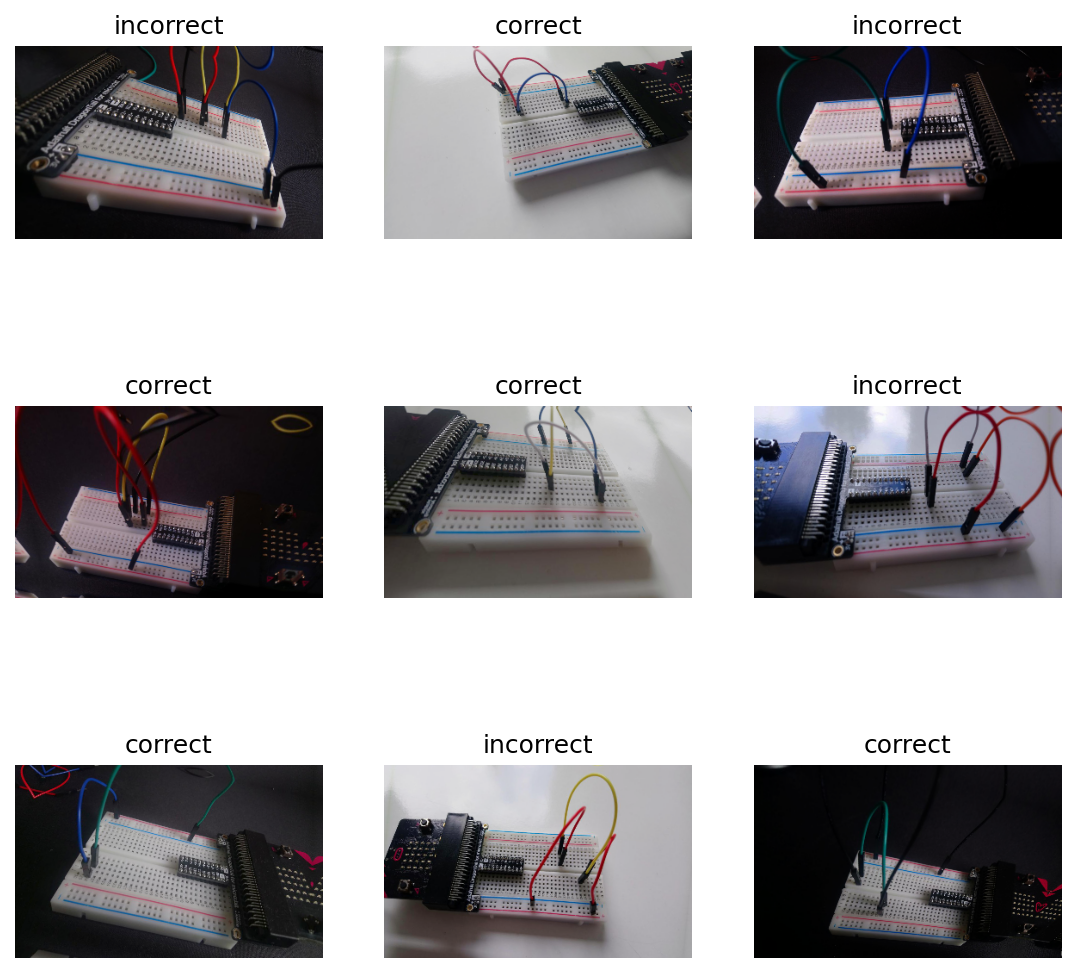

In [6]:
dls = get_loaders(224, bs = bs)
dls.show_batch()

In [7]:
learn = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy, error_rate])

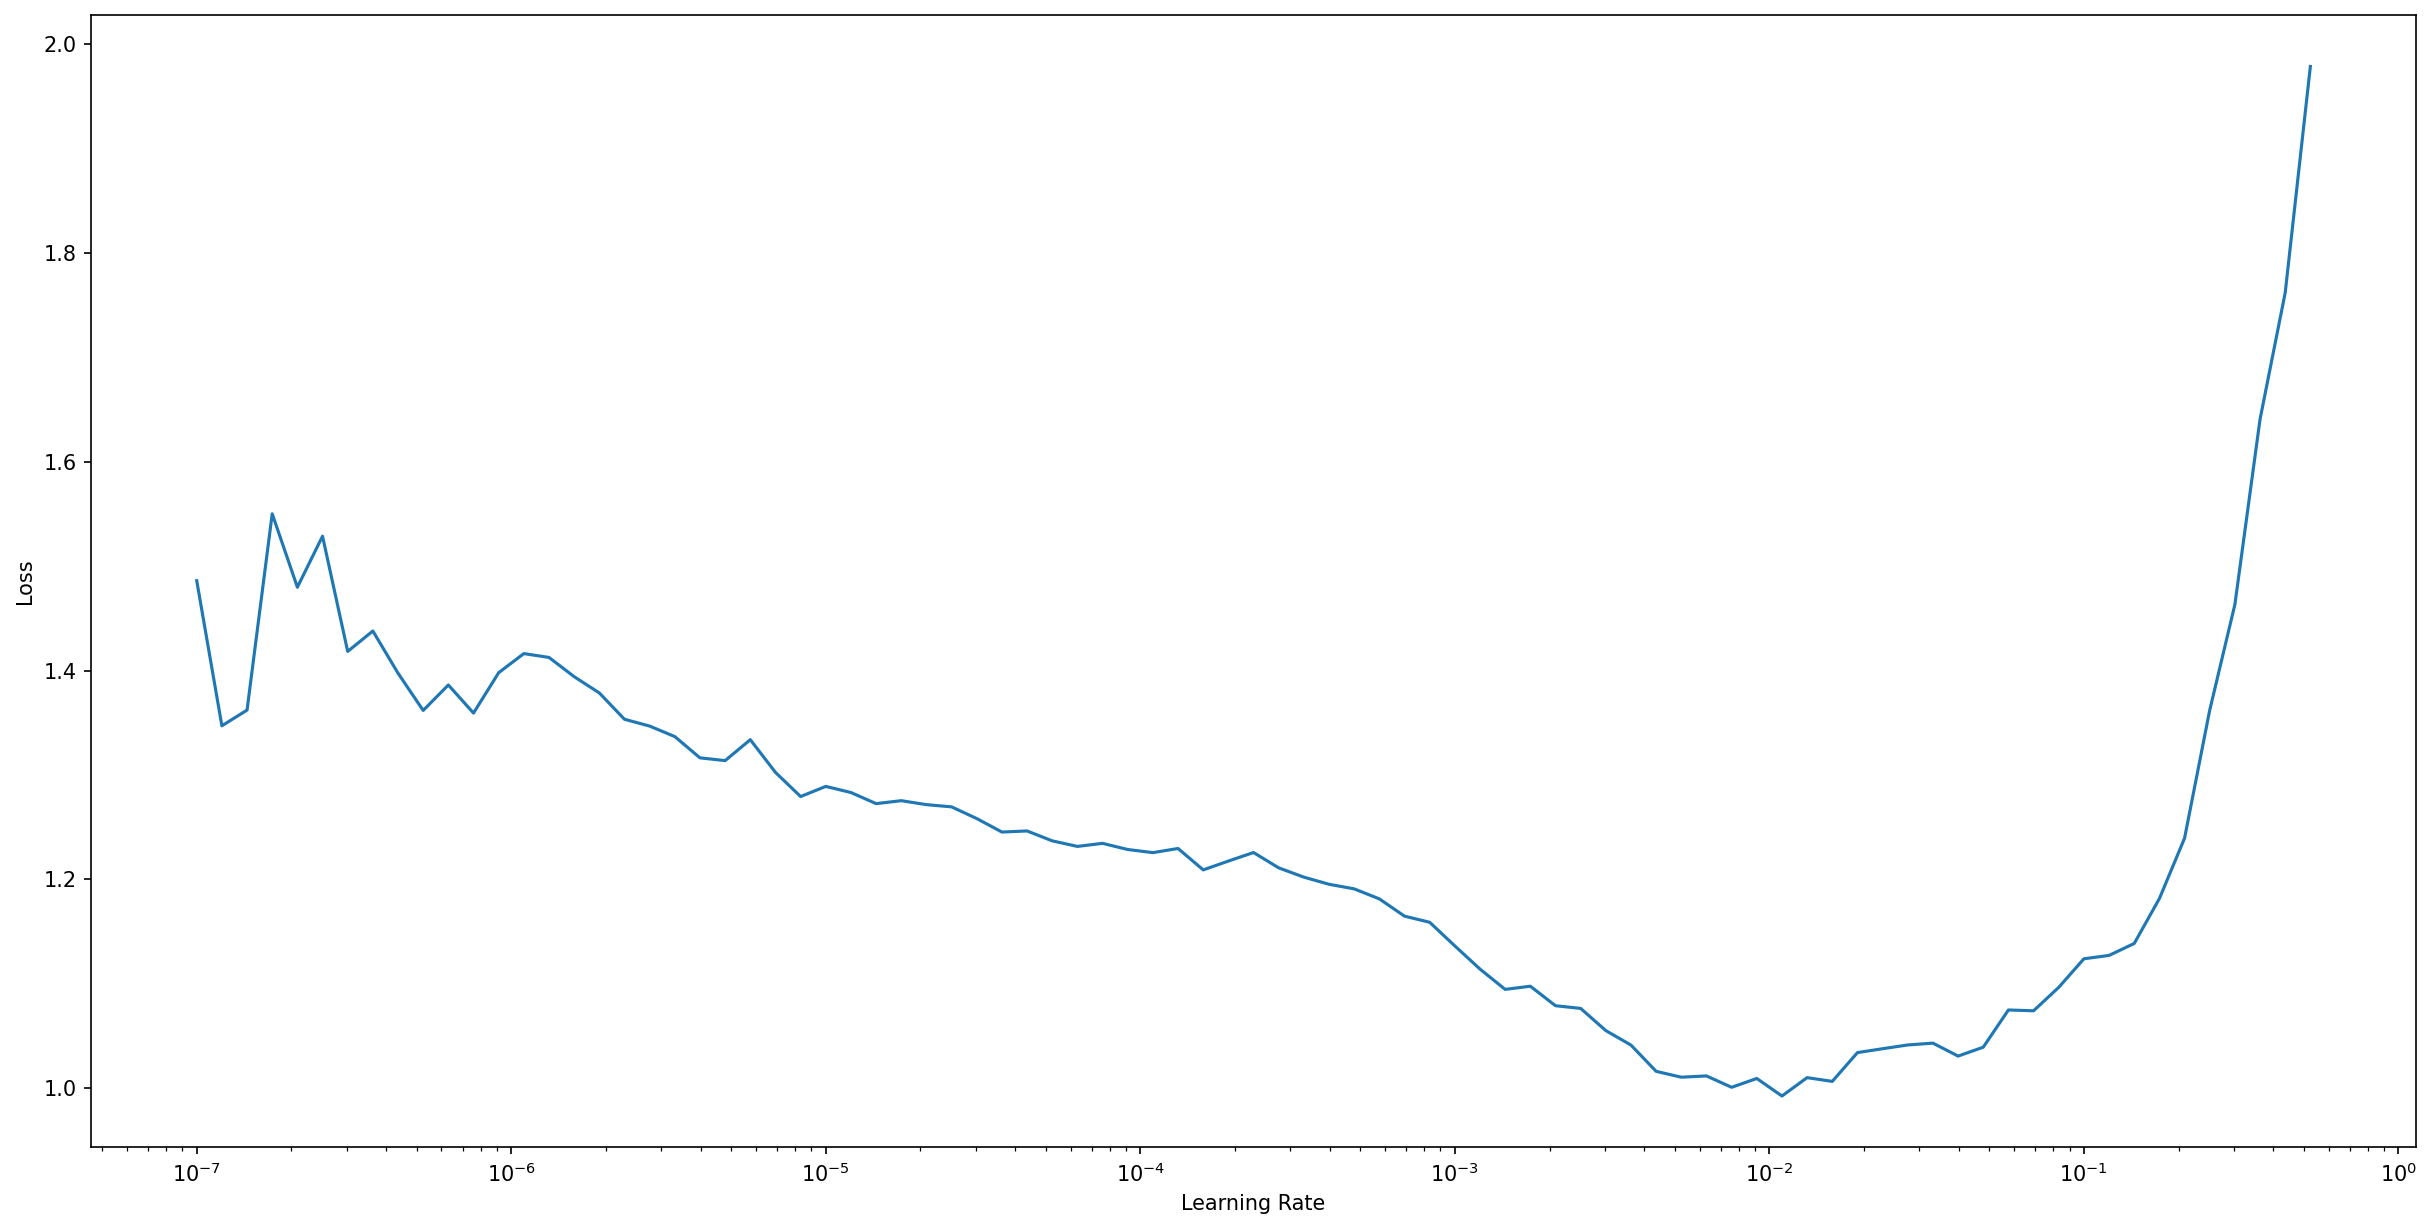

In [8]:
lr_min, _ = learn.lr_find()

In [9]:
learn.save('res50-224-pre') # 0.460, 0.396, 0.8548 / 0.1451

Path('models/res50-224-pre.pth')

In [10]:
learn.fine_tune(15, base_lr = lr_min)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.322693,0.668496,0.612903,0.387097,00:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.965357,0.499467,0.725806,0.274194,00:04
1,0.791001,0.465016,0.774194,0.225806,00:04
2,0.723357,0.526113,0.774194,0.225806,00:04
3,0.651094,0.474952,0.790323,0.209677,00:04
4,0.610816,0.525905,0.838710,0.161290,00:04
5,0.564690,0.389980,0.870968,0.129032,00:04
6,0.497503,0.350331,0.919355,0.080645,00:04
7,0.450350,0.267565,0.935484,0.064516,00:04
8,0.399216,0.266580,0.919355,0.080645,00:04
9,0.382723,0.321446,0.903226,0.096774,00:04


In [11]:
learn.save('res50-224-cold')

Path('models/res50-224-cold.pth')

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=6.309573450380412e-07)

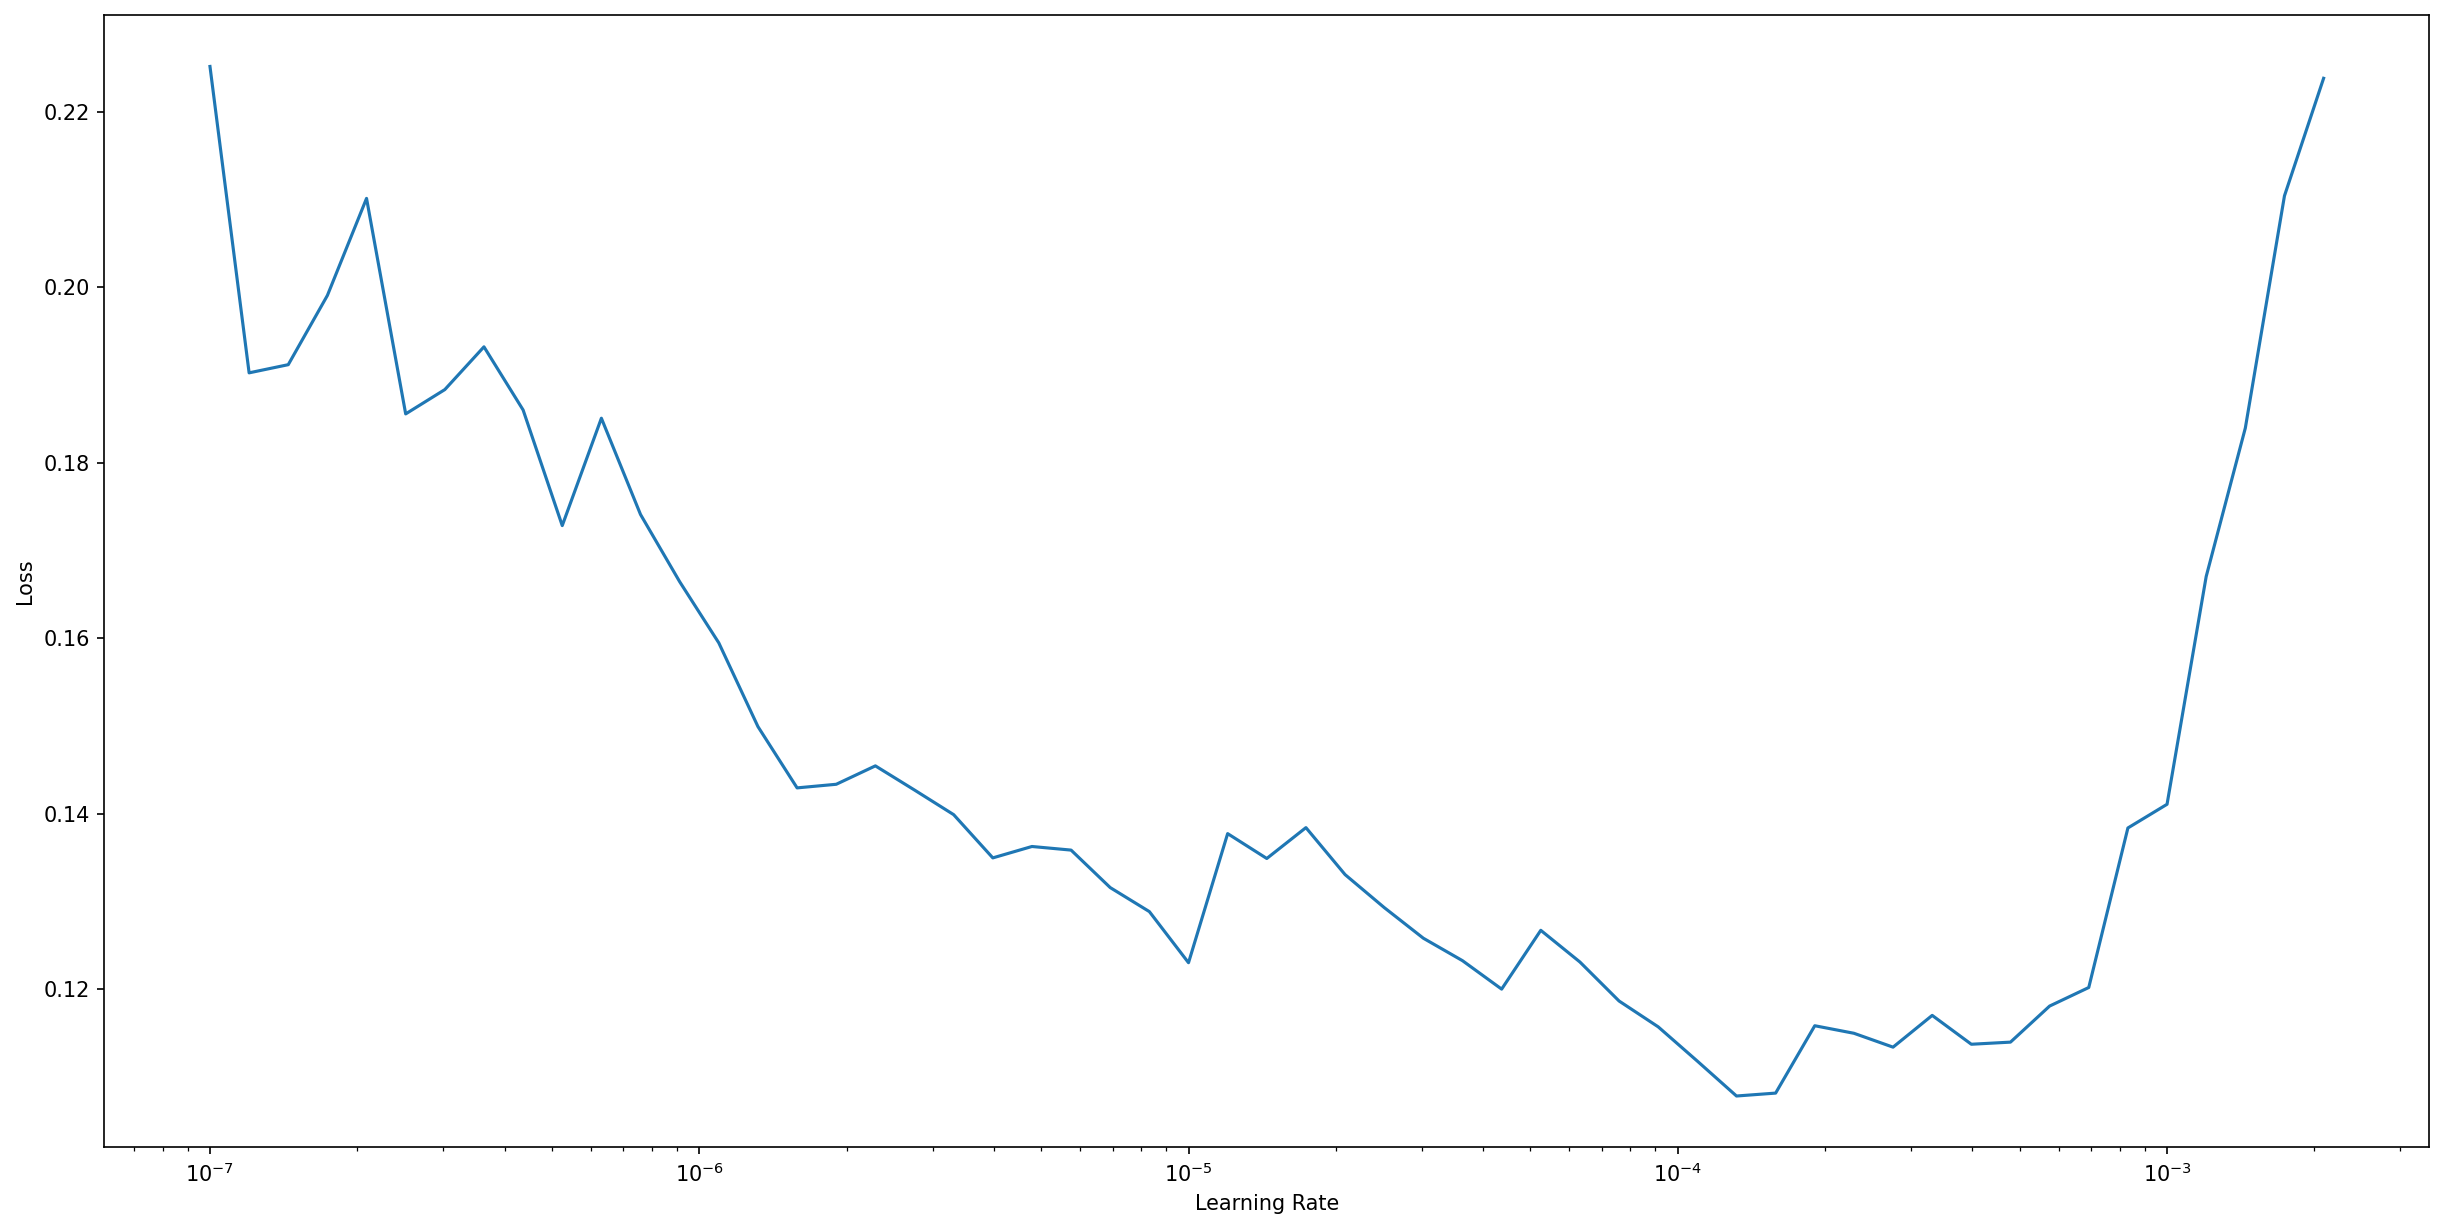

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(15, slice(1e-7,1e-3))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.246662,0.265365,0.919355,0.080645,00:04
1,0.160677,0.295689,0.919355,0.080645,00:04
2,0.133012,0.423972,0.887097,0.112903,00:04
3,0.143006,0.603690,0.870968,0.129032,00:04
4,0.139010,0.185486,0.903226,0.096774,00:04
5,0.137559,0.297260,0.919355,0.080645,00:04
6,0.150698,0.163913,0.935484,0.064516,00:04
7,0.137280,0.125249,0.935484,0.064516,00:04
8,0.153544,0.207067,0.919355,0.080645,00:04
9,0.152756,0.251978,0.935484,0.064516,00:04


In [14]:
learn.save('res50-224-hot')

Path('models/res50-224-hot.pth')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

In [ ]:
plt.rcParams['figure.dpi'] = 300
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Transfer learning
There is no obvious group of pictures the learner performs poorly on, so increase imagesize.

In [6]:
dls = get_loaders(420, bs = bs//4) # half batchsize for image size increase

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy, error_rate])

In [7]:
learn.load('res50-224-hot')

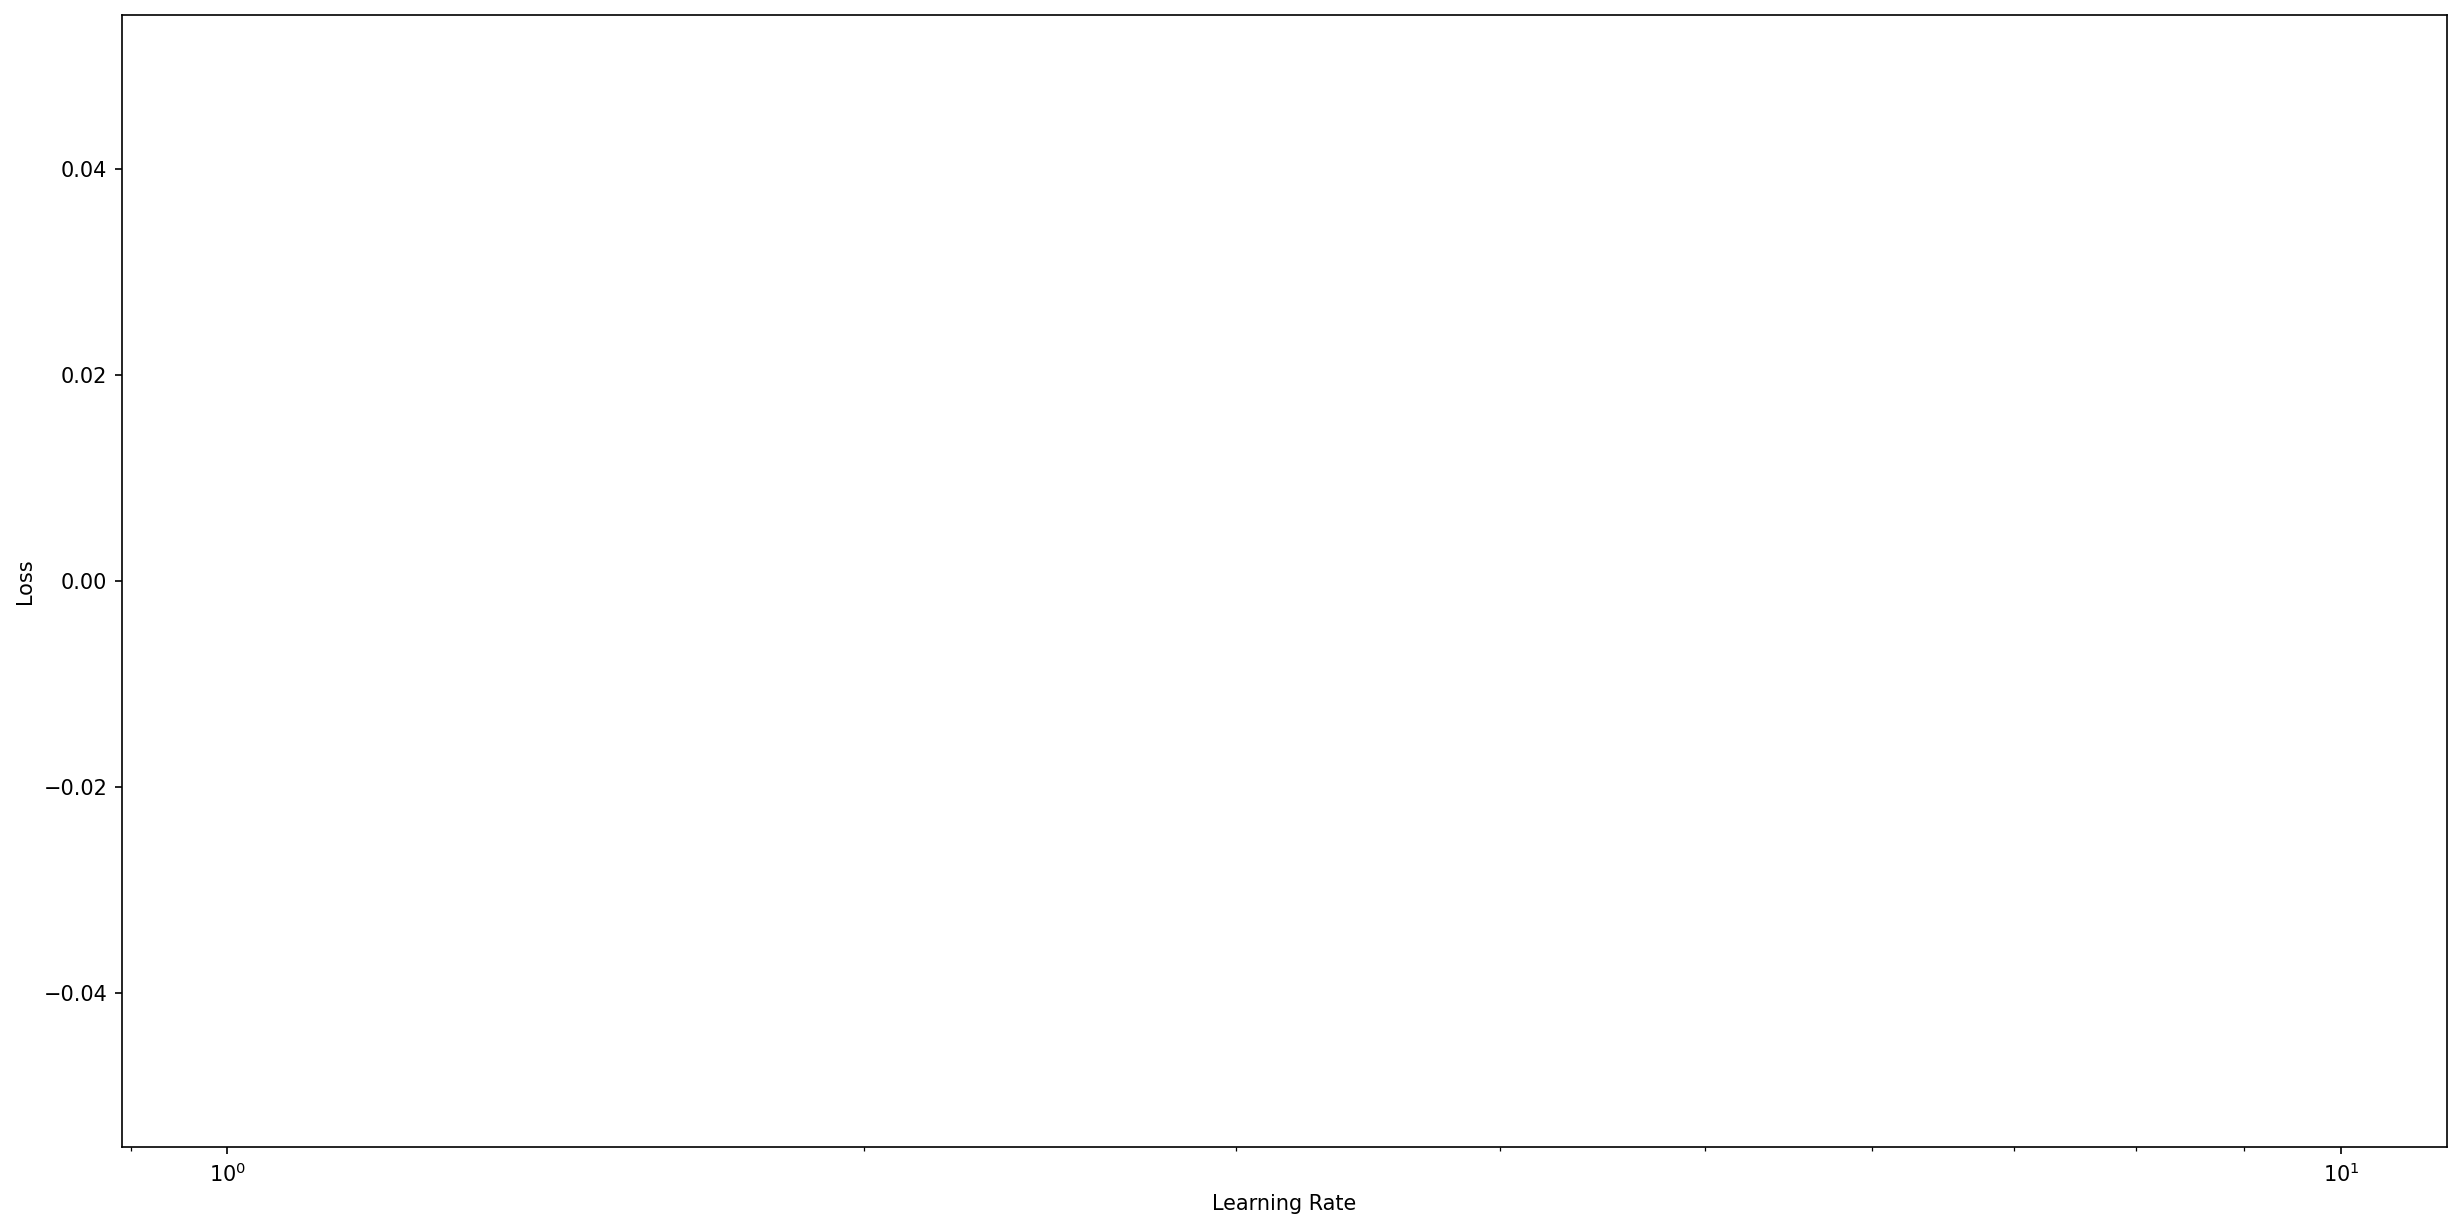

In [8]:
learn.lr_find()

In [9]:
learn.fine_tune(15, 2e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.541876,0.435215,0.838710,0.161290,00:09


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.428618,0.257680,0.919355,0.080645,00:12
1,0.402443,0.130289,0.919355,0.080645,00:11
2,0.529611,0.111225,0.951613,0.048387,00:11
3,0.441913,0.112398,0.935484,0.064516,00:11
4,0.409981,0.175993,0.919355,0.080645,00:11
5,0.364616,0.204212,0.919355,0.080645,00:11
6,0.364381,0.142346,0.919355,0.080645,00:11
7,0.322326,0.172927,0.919355,0.080645,00:11
8,0.377081,0.172838,0.919355,0.080645,00:12
9,0.319853,0.113403,0.935484,0.064516,00:12


In [10]:
learn.save('res50-420-cold')

Path('models/res50-420-cold.pth')

In [11]:
#learn.load('res34-420-cold')

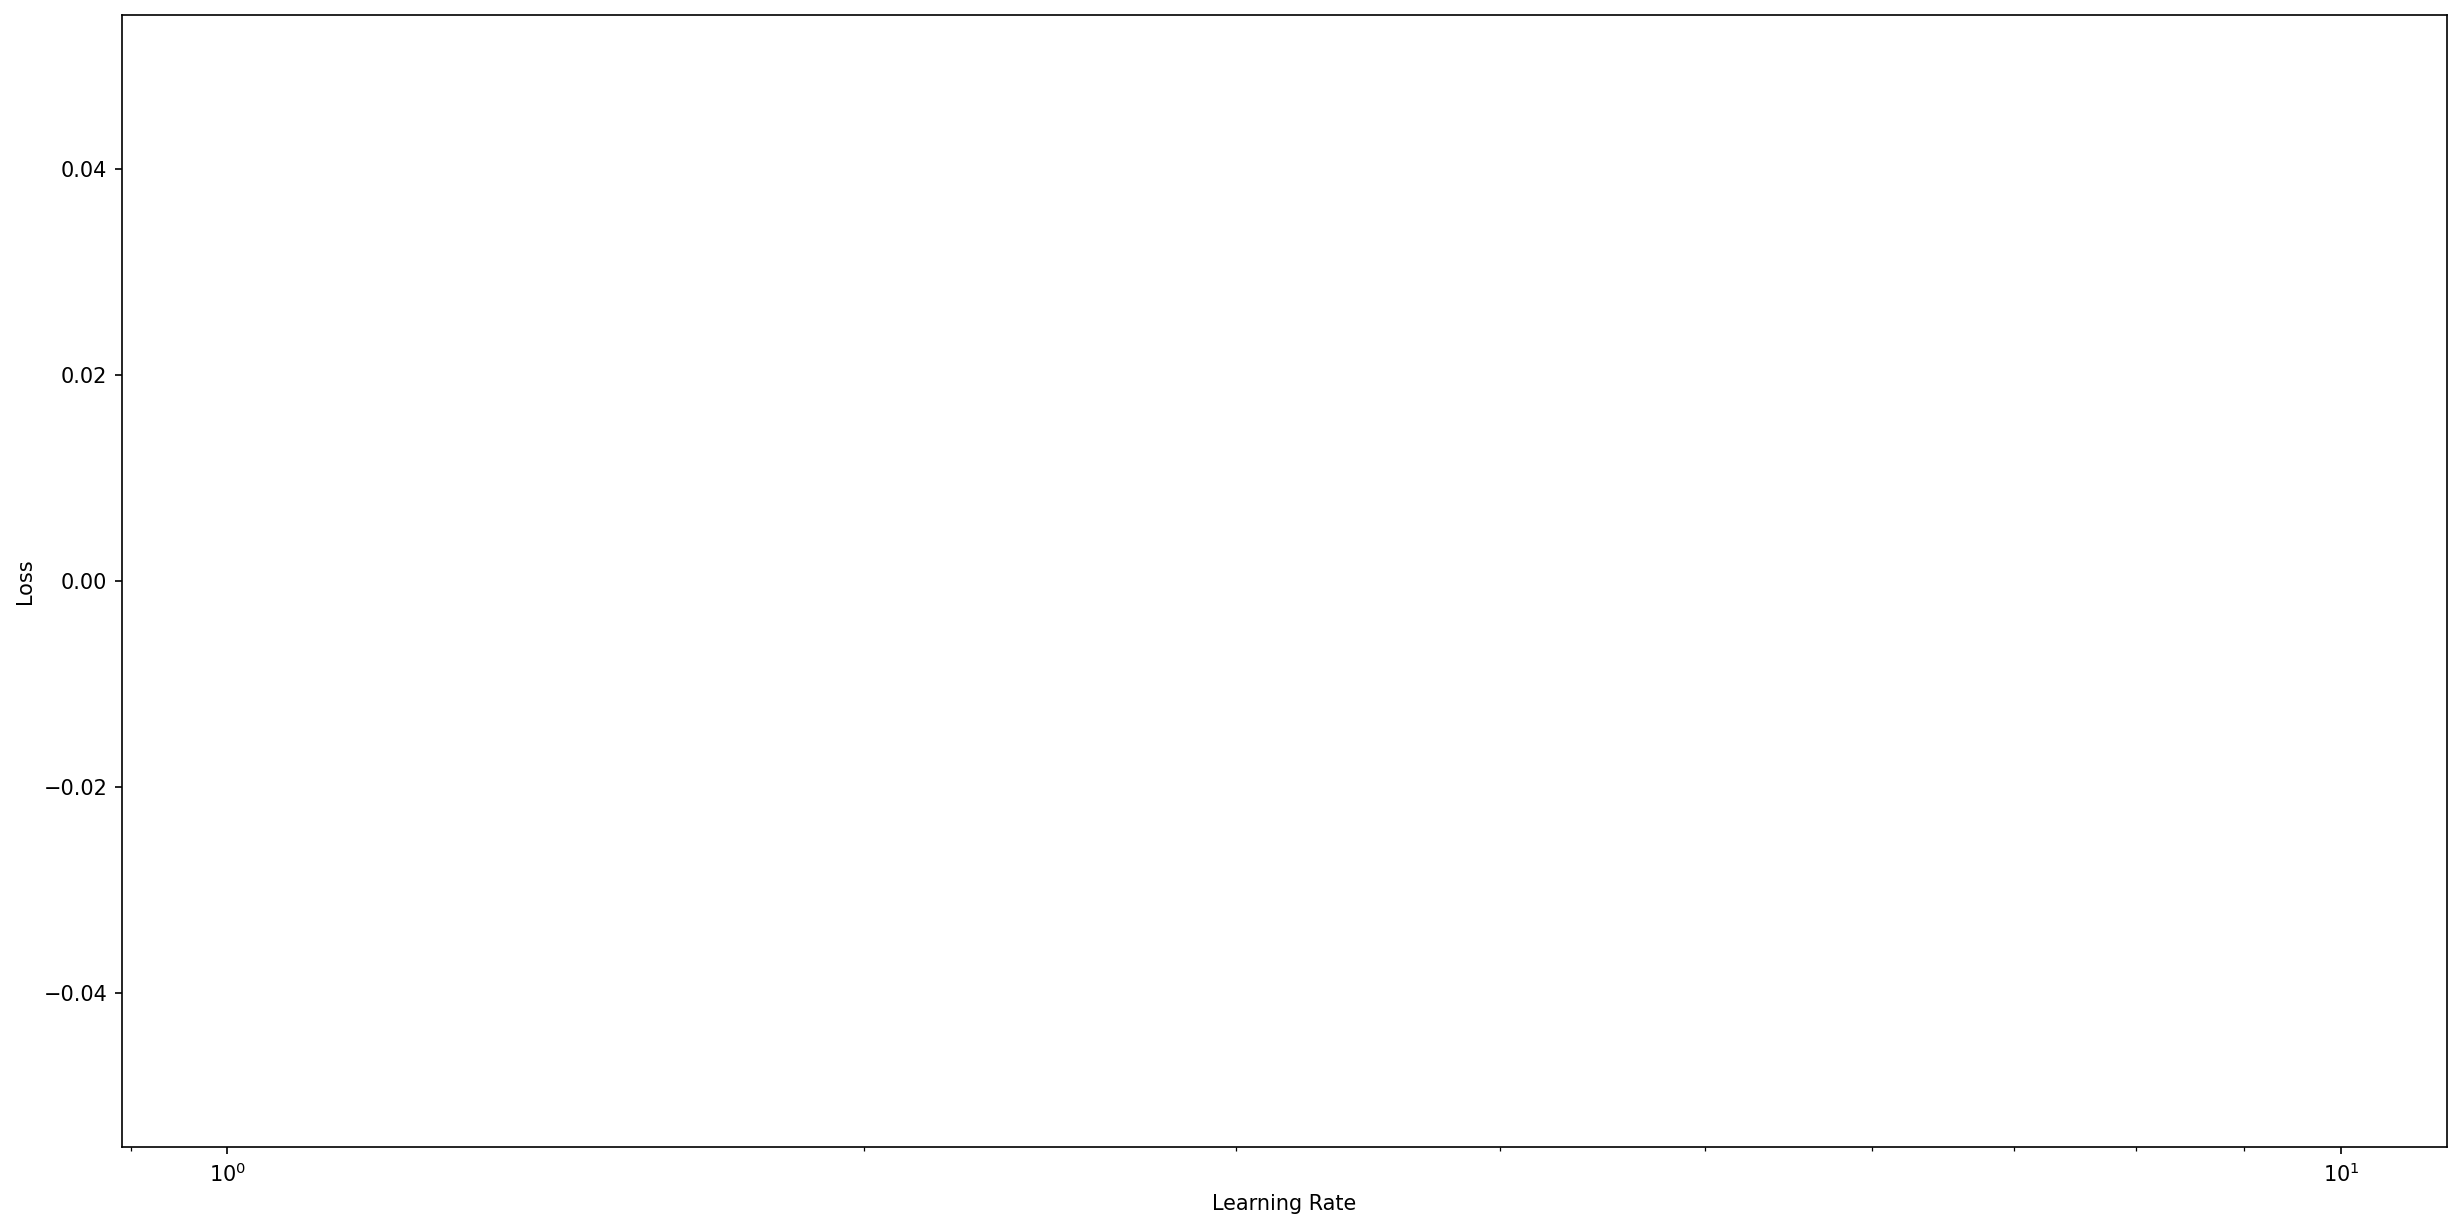

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(15, slice(1e-4/200,1e-4/2))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.213415,0.123226,0.967742,0.032258,00:11
1,0.337972,0.115823,0.951613,0.048387,00:12
2,0.301257,0.048832,0.967742,0.032258,00:12
3,0.209771,0.081789,0.951613,0.048387,00:12
4,0.228264,0.064722,0.951613,0.048387,00:12
5,0.190002,0.111426,0.951613,0.048387,00:12
6,0.228357,0.063253,0.967742,0.032258,00:12
7,0.211415,0.058805,0.967742,0.032258,00:12
8,0.173972,0.096247,0.951613,0.048387,00:12
9,0.179515,0.075698,0.967742,0.032258,00:12


In [14]:
learn.save('res50-420-hot')

Path('models/res50-420-hot.pth')

In [15]:
dls = get_loaders(640, bs = bs//8)

learn = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy, error_rate])

In [16]:
learn.load('res50-420-hot')

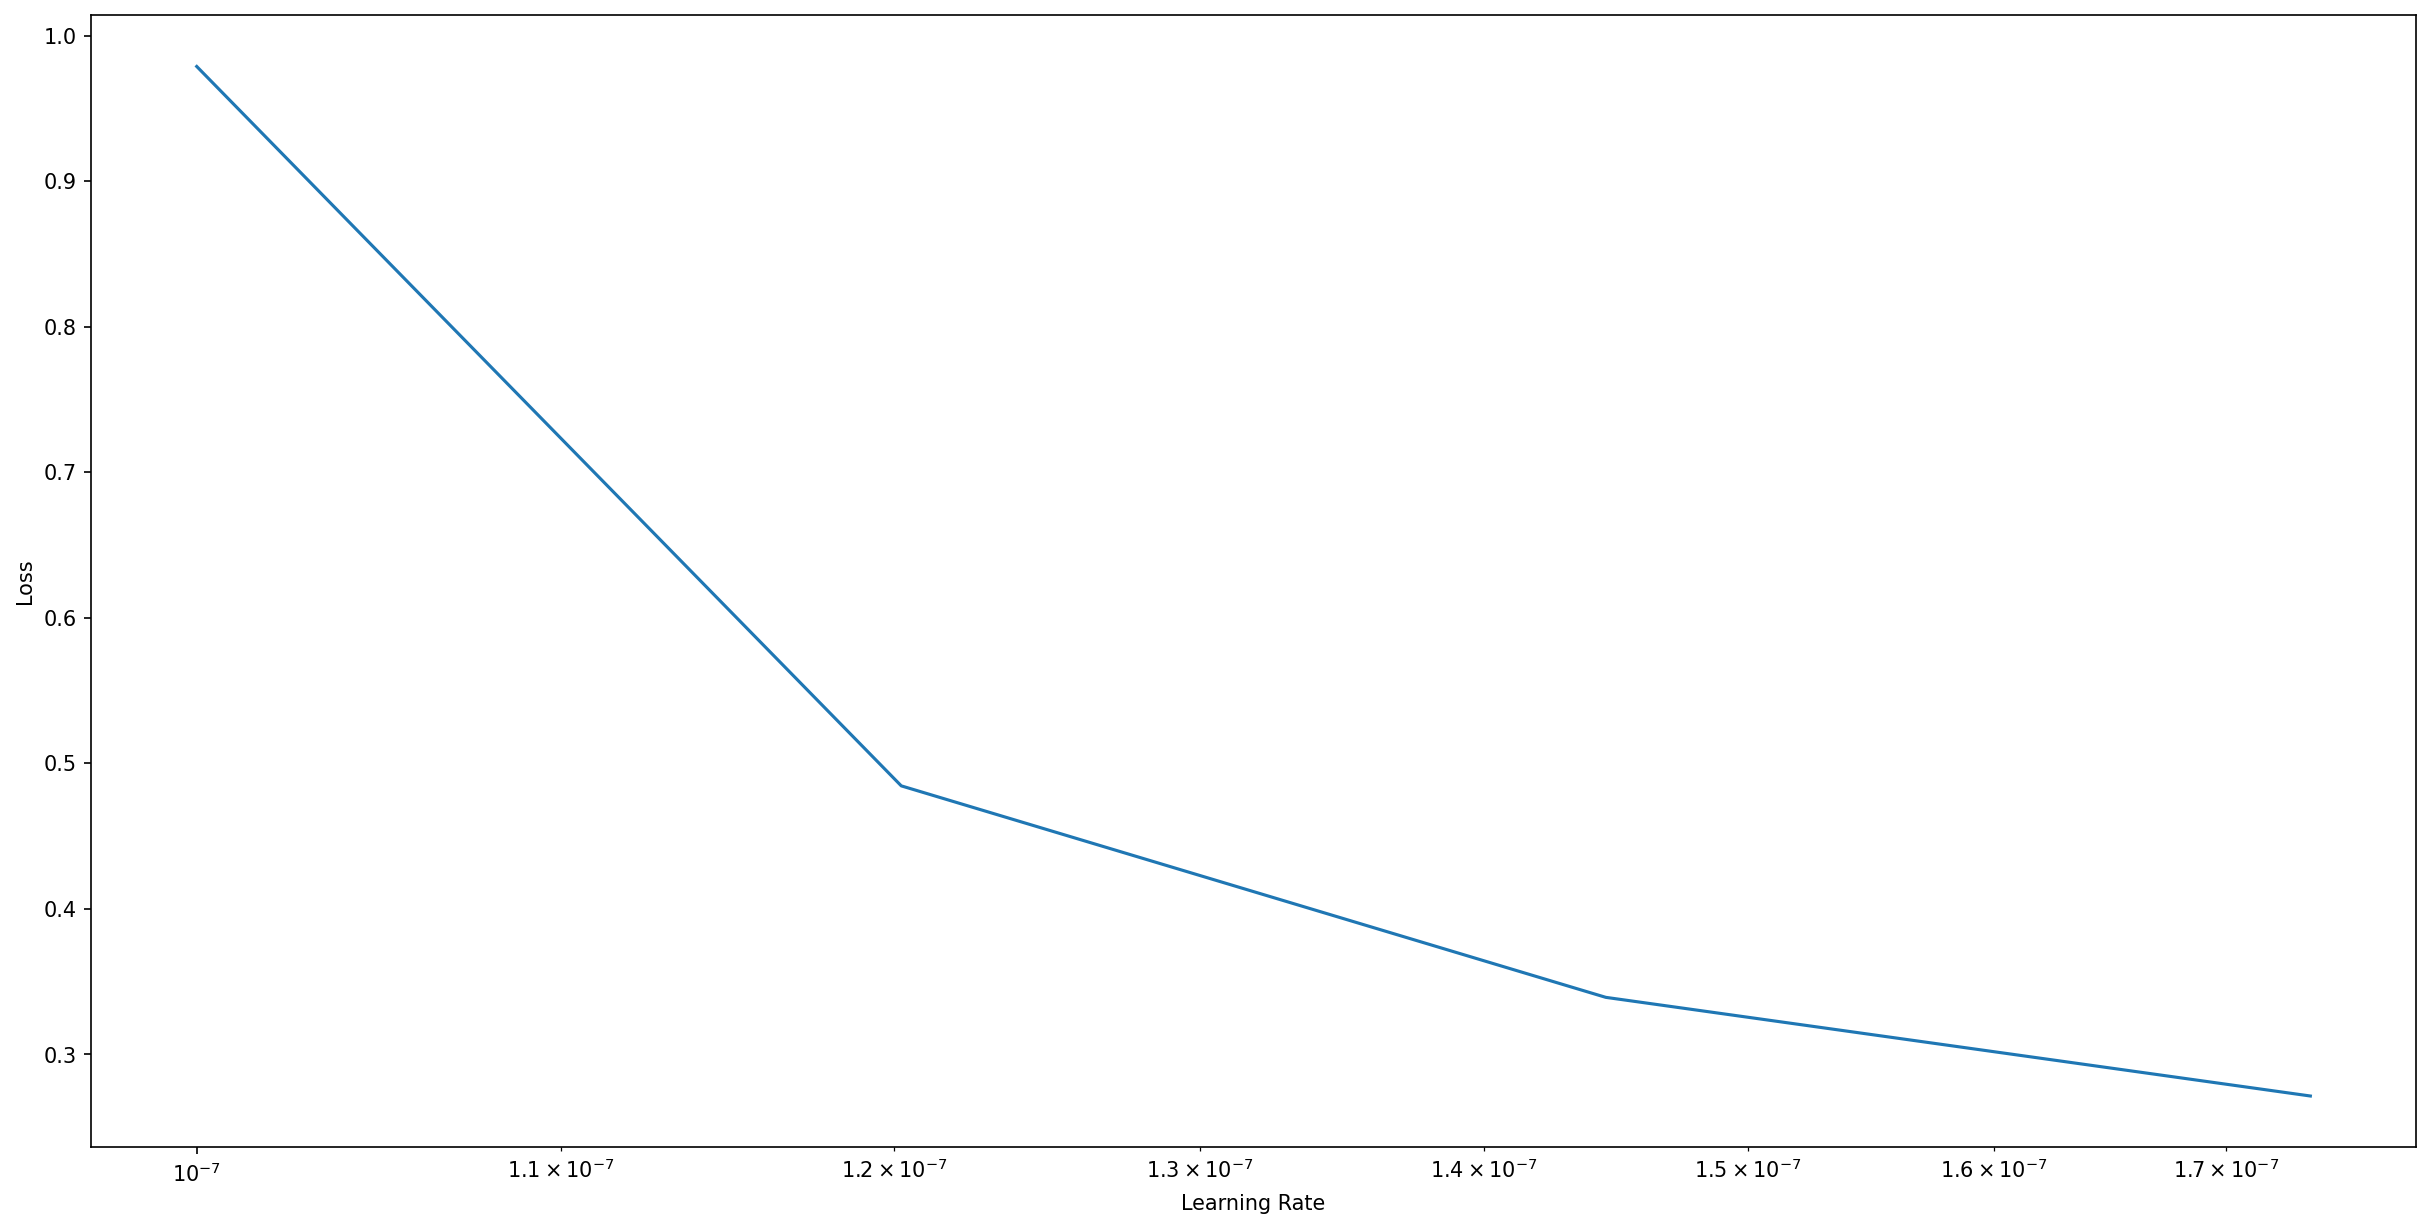

In [17]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.save('res50-640-pre')

In [18]:
learn.fine_tune(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.585171,0.341113,0.870968,0.129032,00:18


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.710316,0.372902,0.887097,0.112903,00:25
1,0.524905,0.272308,0.870968,0.129032,00:25
2,0.479207,0.379373,0.854839,0.145161,00:25
3,0.553496,0.230788,0.935484,0.064516,00:25
4,0.548575,0.663507,0.709677,0.290323,00:25
5,0.594707,0.353390,0.854839,0.145161,00:25
6,0.498542,0.455608,0.838710,0.161290,00:25
7,0.514568,0.610397,0.725806,0.274194,00:25
8,0.473849,0.405485,0.774194,0.225806,00:24
9,0.336605,0.226924,0.887097,0.112903,00:23


In [19]:
learn.save('res50-640-cold')

Path('models/res50-640-cold.pth')

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=3.981071586167673e-06)

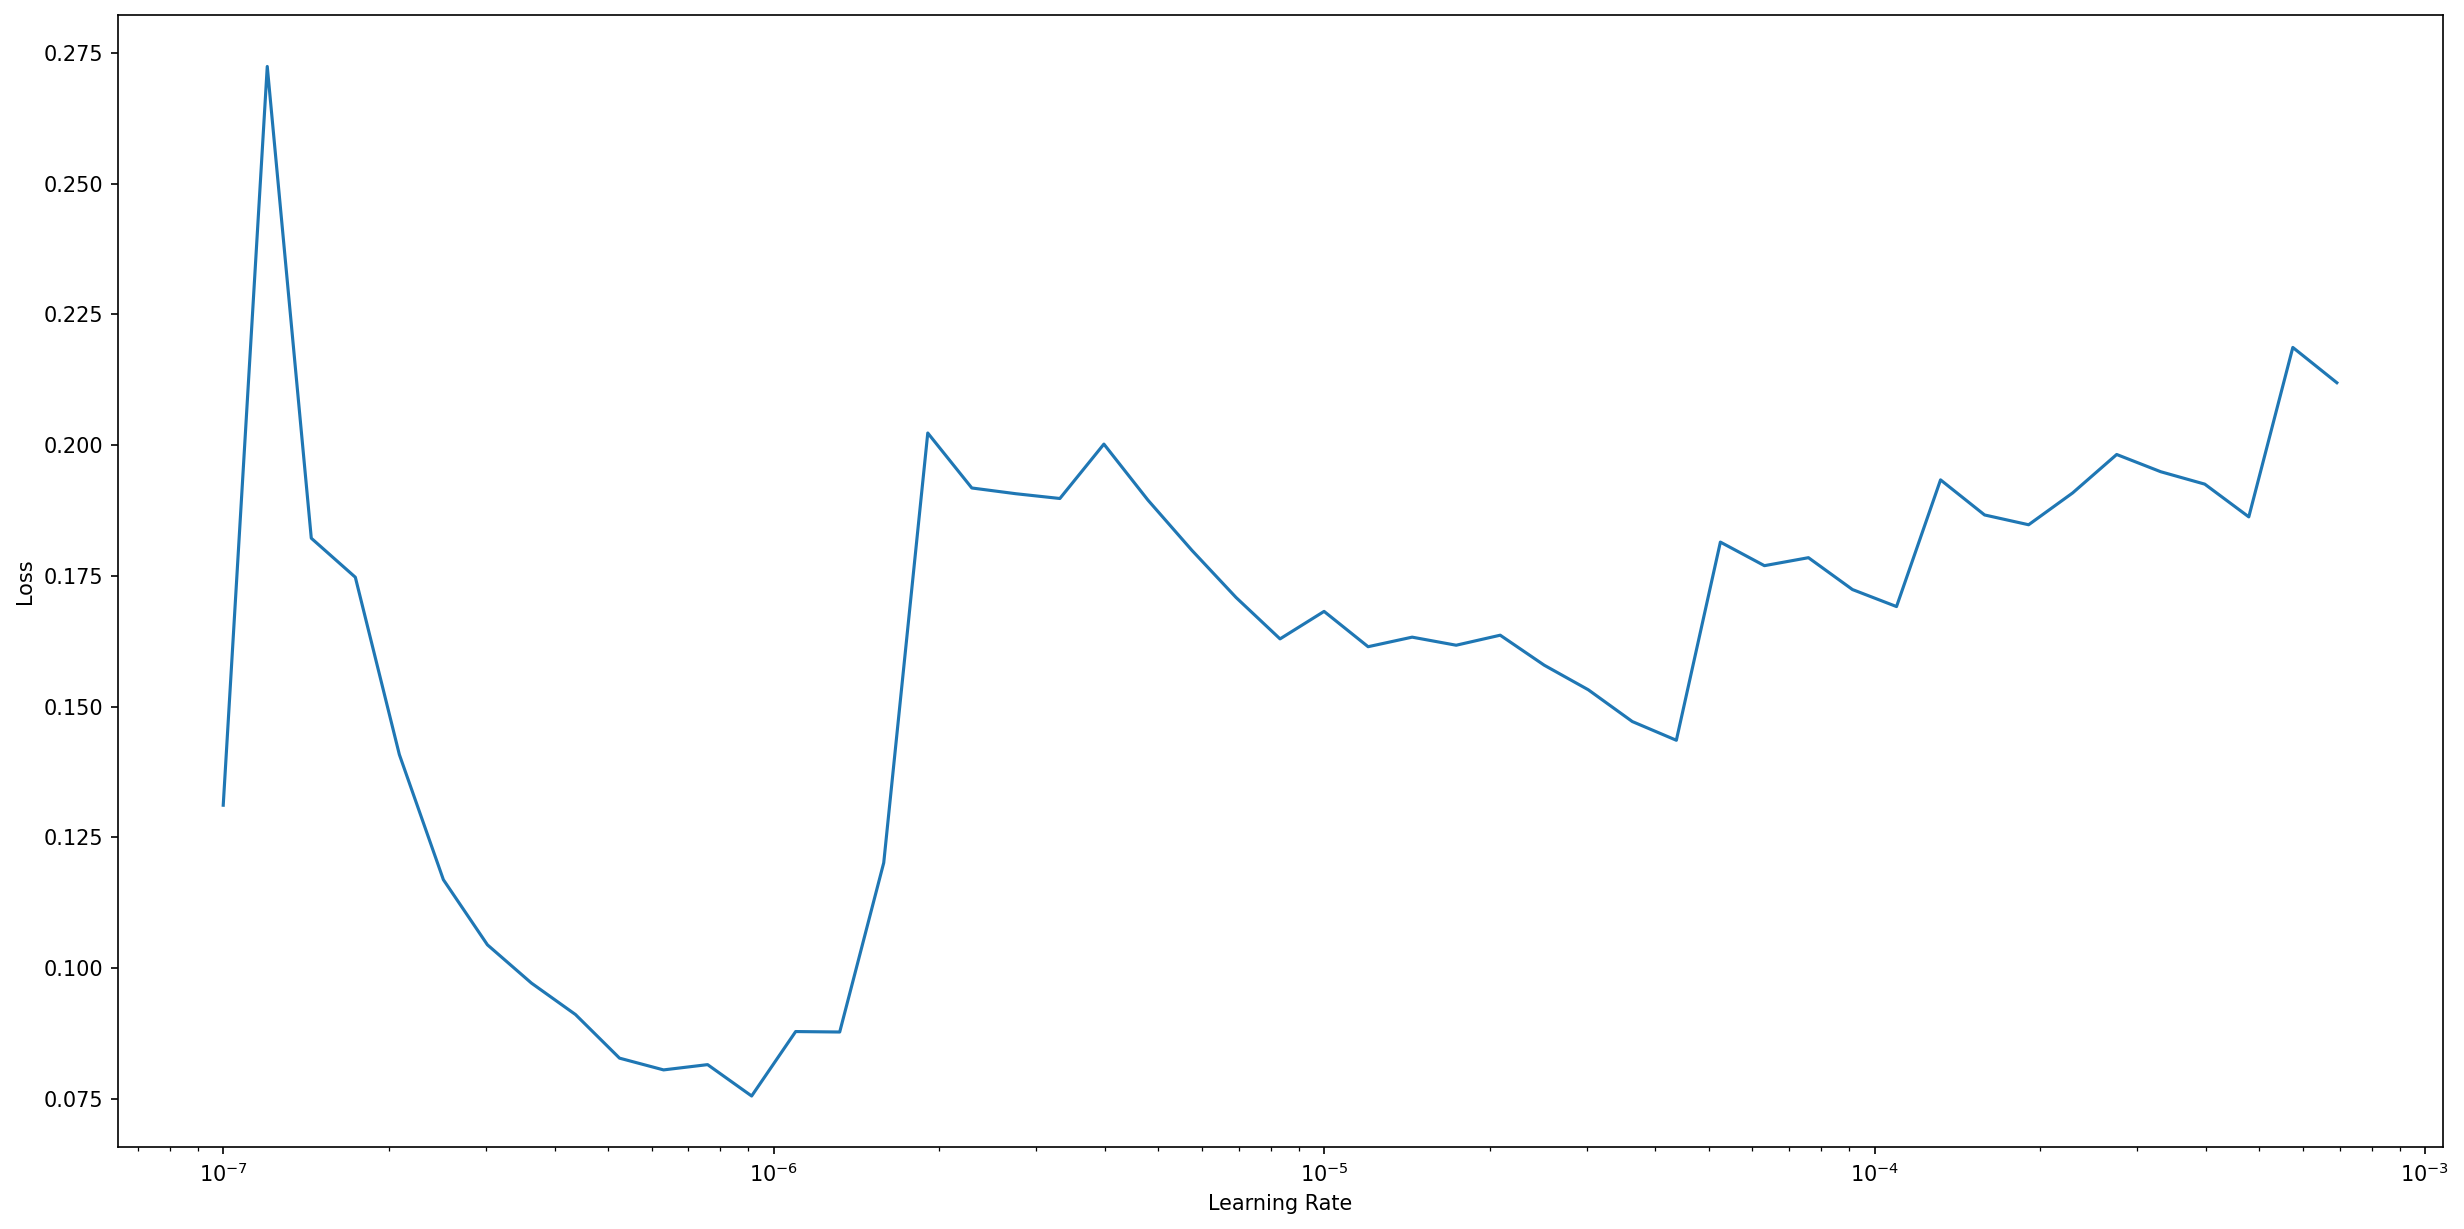

In [20]:
learn.unfreeze()
learn.lr_find()

In [21]:
learn.fit_one_cycle(20, slice(1e-6,2e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.474087,0.158057,0.951613,0.048387,00:23
1,0.304923,0.119401,0.935484,0.064516,00:23
2,0.338666,0.125431,0.935484,0.064516,00:23
3,0.331037,0.115292,0.967742,0.032258,00:23
4,0.298925,0.172758,0.951613,0.048387,00:23
5,0.366690,0.117586,0.967742,0.032258,00:23
6,0.332846,0.127270,0.951613,0.048387,00:23
7,0.326489,0.106051,0.967742,0.032258,00:23
8,0.323083,0.130963,0.935484,0.064516,00:23
9,0.306983,0.105035,0.967742,0.032258,00:23


In [22]:
learn.save('res50-640-hot')

Path('models/res50-640-hot.pth')